In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.sparse as sp
import cupyx.scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.constants import pi, speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9                    
ps = 1e-12                    

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI**2 / meV / c**2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 15

x_min = -75
x_max = 150
t_min = 0
t_max = 20

x0 = 0
x1 = 75
t0 = 0
t1 = 2

In [2]:
data = np.load("../results/analytical/crank.npz")

In [3]:
real = data["real"]
img = data["img"]
x_values = data["x_values"]
t_values = data["t_values"]

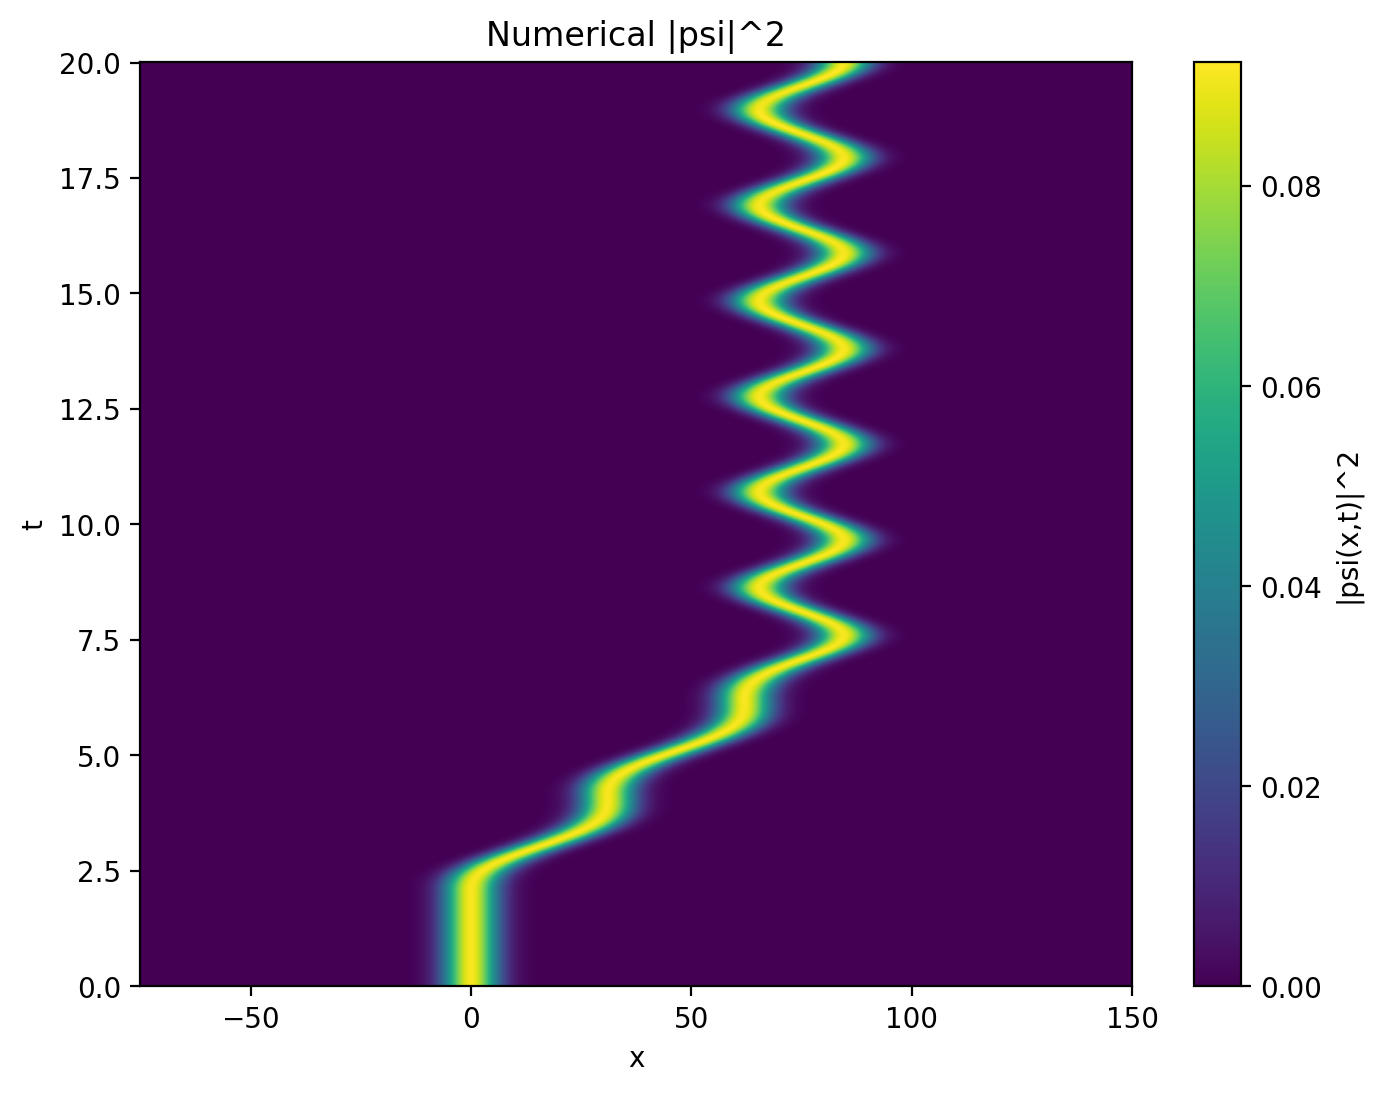

In [4]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq = real ** 2 + img ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Numerical |psi|^2')
plt.show()

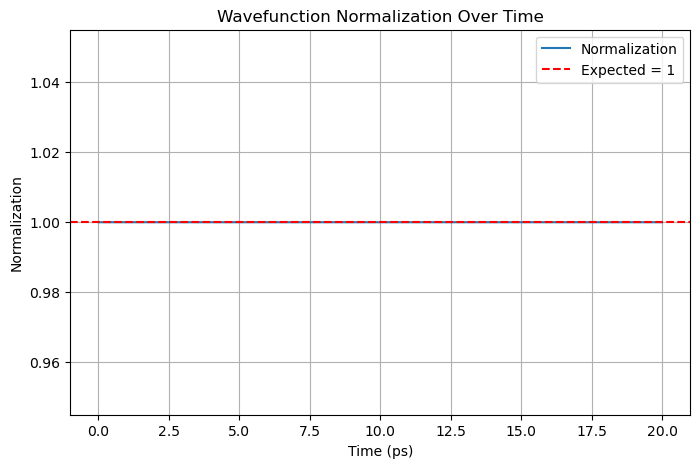

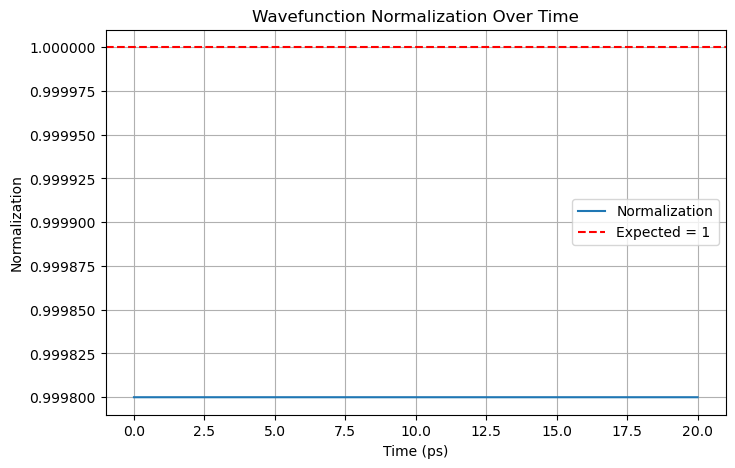

In [13]:
from scipy.integrate import simpson

norms = []
norms_monte = []

for i in range(5000):
  psi_sq_i = real[:, i] ** 2 + img[:, i] ** 2
  normalization = simpson(psi_sq_i, x=x_values)
  normalization_monte = np.mean(psi_sq_i) * (x_max - x_min)
  norms.append(np.round(normalization, 5))
  norms_monte.append(normalization_monte)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms_monte, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)

plt.show()

In [12]:
np.mean(psi_sq)

0.004443555555554933

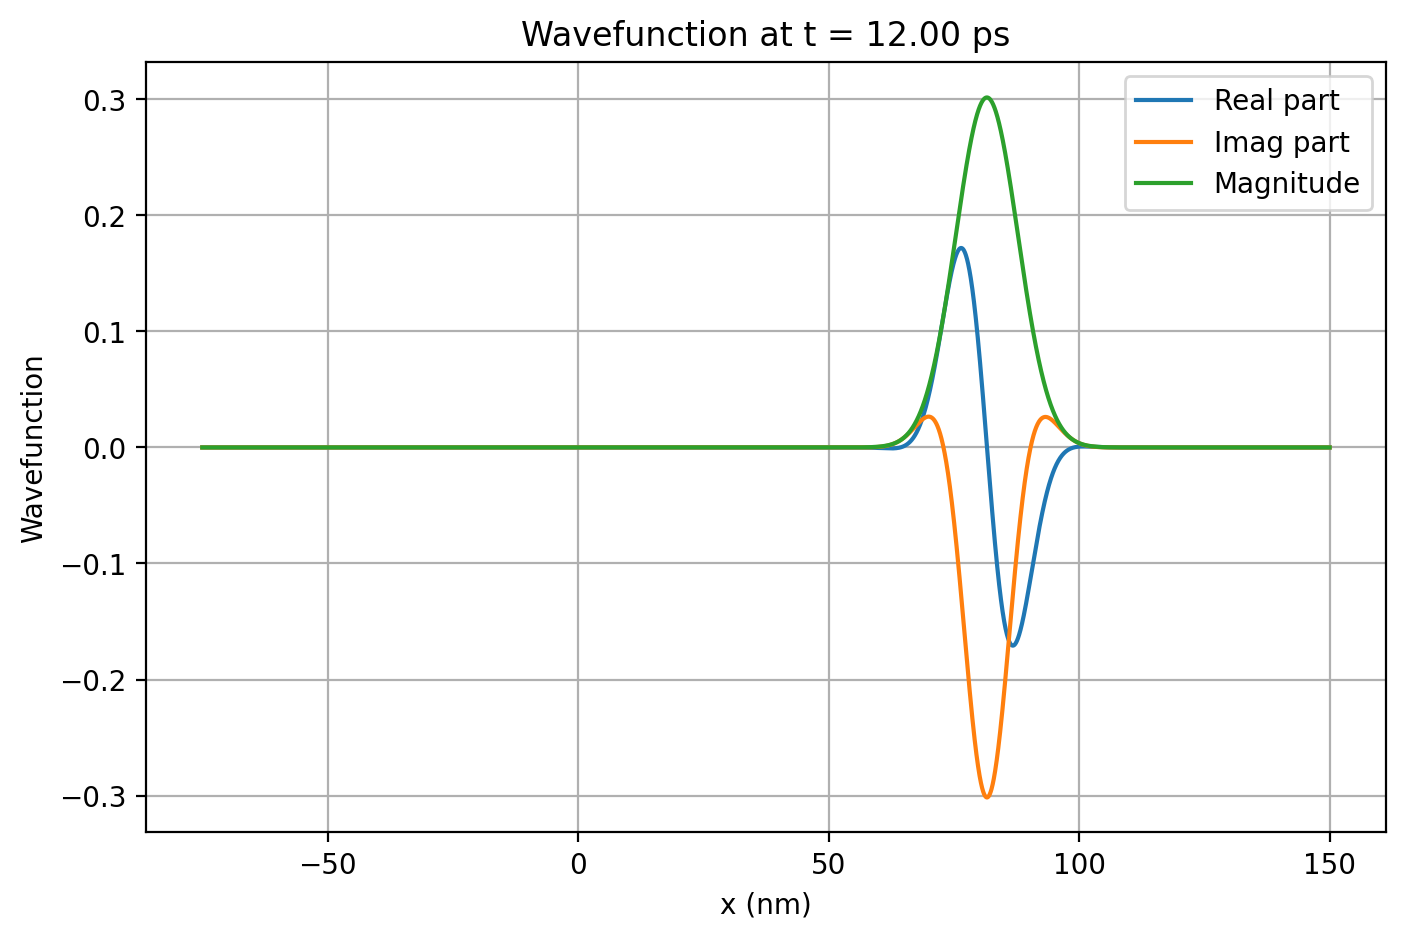

In [6]:
time_index = 3000
time_chosen = t_values[time_index]

psi_real_slice_pinn = real[:, time_index]
psi_img_slice_pinn = img[:, time_index]

psi_mag_slice_pinn = np.sqrt(psi_real_slice_pinn ** 2 + psi_img_slice_pinn ** 2)

plt.figure(figsize=(8,5), dpi=200)
plt.plot(x_values, psi_real_slice_pinn, label='Real part')
plt.plot(x_values, psi_img_slice_pinn, label='Imag part')
plt.plot(x_values, psi_mag_slice_pinn, label='Magnitude')
plt.title(f'Wavefunction at t = {time_chosen:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('Wavefunction')
plt.legend()
plt.grid(True)
plt.show()


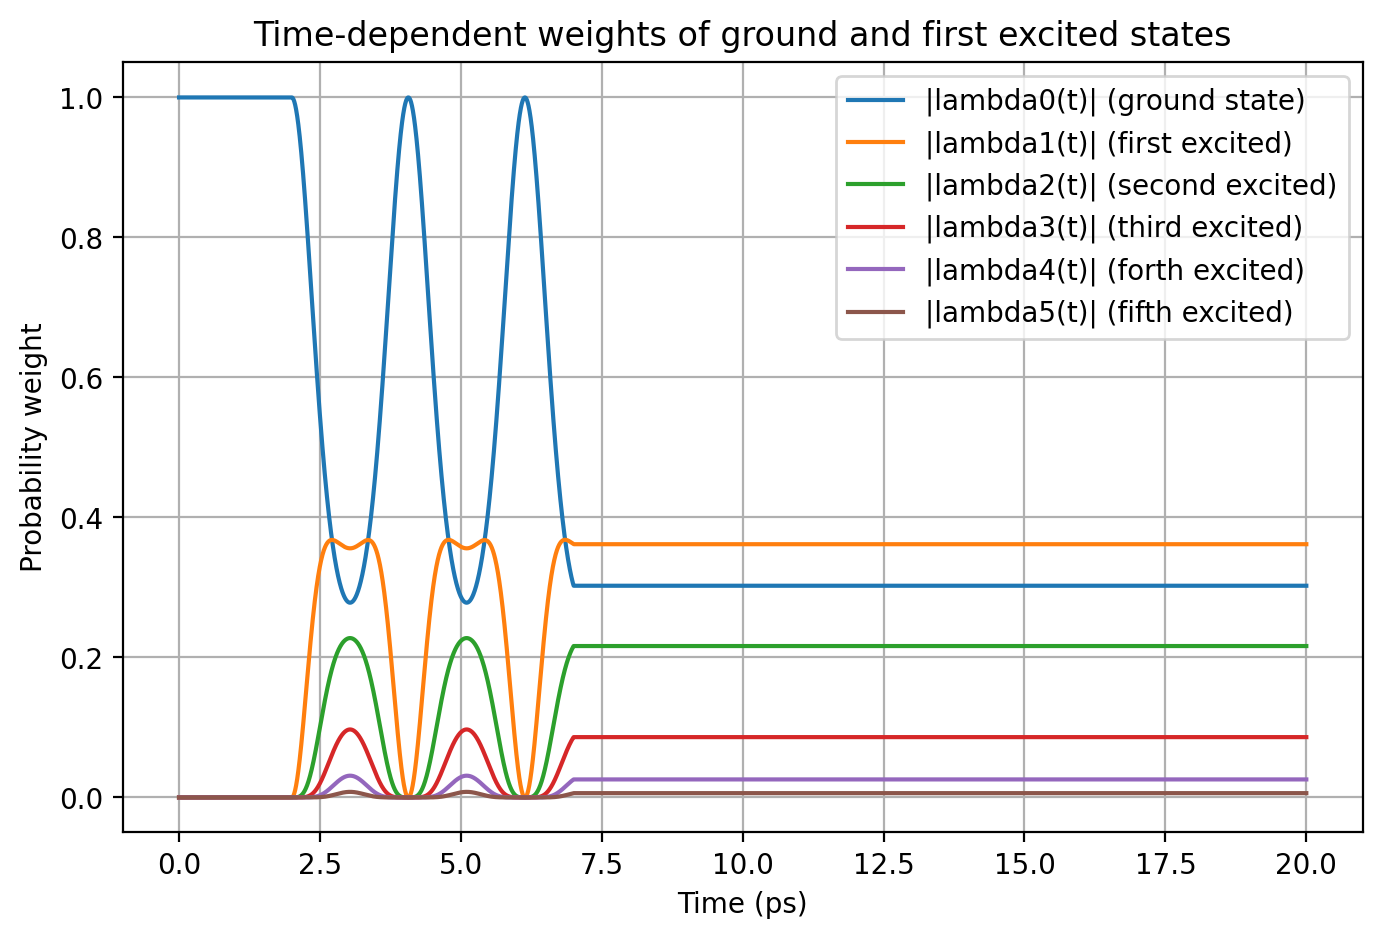

In [7]:
from scipy import special

psi_pinn = real + 1j * img

def quantum_center(t):
    if t < t1:
        return x0
    elif t < t1 + (x1 - x0) / vQD:
        return x0 + vQD * (t - t1)
    else:
        return x1
    
def psi_x_n(x, t, n):
    A = 1 / np.sqrt((2 ** n) * special.factorial(n))
    B = ((m * omega) / (np.pi * hbar)) ** (1/4)
    C = np.exp((-m * omega * (x - quantum_center(t)) ** 2) / (2 * hbar))
    D = special.eval_hermite(n, np.sqrt((m * omega) / hbar) * (x - quantum_center(t)))
    return A * B * C * D

def psi_x_t_n(x, t, n):
    A = psi_x_n(x, t, n)
    En = (n + (1/2)) * hbar * omega
    B = np.exp(-(1j * En * t) / hbar)
    return A * B

lambda0, lambda1 = [], []
lambda2, lambda3 = [], []
lambda4, lambda5 = [], []

for i, t in enumerate(t_values):
    psi = psi_pinn[:, i]
    
    psi0_t = psi_x_t_n(x_values, t, 0)
    psi1_t = psi_x_t_n(x_values, t, 1)
    psi2_t = psi_x_t_n(x_values, t, 2)
    psi3_t = psi_x_t_n(x_values, t, 3)
    psi4_t = psi_x_t_n(x_values, t, 4)
    psi5_t = psi_x_t_n(x_values, t, 5)
    
    lambda0_i = simpson(psi * np.conj(psi0_t), x=x_values)
    lambda1_i = simpson(psi * np.conj(psi1_t), x=x_values)
    lambda2_i = simpson(psi * np.conj(psi2_t), x=x_values)
    lambda3_i = simpson(psi * np.conj(psi3_t), x=x_values)
    lambda4_i = simpson(psi * np.conj(psi4_t), x=x_values)
    lambda5_i = simpson(psi * np.conj(psi5_t), x=x_values)
    
    lambda0.append(np.abs(lambda0_i) ** 2)
    lambda1.append(np.abs(lambda1_i) ** 2)
    lambda2.append(np.abs(lambda2_i) ** 2)
    lambda3.append(np.abs(lambda3_i) ** 2)
    lambda4.append(np.abs(lambda4_i) ** 2)
    lambda5.append(np.abs(lambda5_i) ** 2)

plt.figure(figsize=(8,5), dpi=200)
plt.plot(t_values, lambda0, label='|lambda0(t)| (ground state)')
plt.plot(t_values, lambda1, label='|lambda1(t)| (first excited)')
plt.plot(t_values, lambda2, label='|lambda2(t)| (second excited)')
plt.plot(t_values, lambda3, label='|lambda3(t)| (third excited)')
plt.plot(t_values, lambda4, label='|lambda4(t)| (forth excited)')
plt.plot(t_values, lambda5, label='|lambda5(t)| (fifth excited)')
plt.xlabel("Time (ps)")
plt.ylabel("Probability weight")
plt.title("Time-dependent weights of ground and first excited states")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
np.savez("../results/analytical/crank_weights.npz", 
        lambda0_analytical=lambda0, 
        lambda1_analytical=lambda1,
        lambda2_analytical=lambda2,
        lambda3_analytical=lambda3,
        lambda4_analytical=lambda4,
        lambda5_analytical=lambda5,
        psi_sq_analytical=psi_sq
	)

In [9]:
np.arange(.2, 20.2, .2,).__len__()

100